# Lecture 2: Network nonparametrics
#### Econometric Methods for Social Spillovers and Networks
#### _University of St. Gallen, September 26th to October 3rd, 2016_
##### _Bryan S. Graham, UC - Berkeley, bgraham@econ.berkeley.edu_
<br>
<br>
This is the first of a series of iPython Jupyter notebooks designed to accompany a series of instructional lectures given at the University of St. Gallen from September 26th to October 3rd, 2016. The scripts below were written for Python 2.7.12. The Anaconda distribution of Python, available at https://www.continuum.io/downloads, comes bundled with most the scientific computing packages used in these notebooks.
<br>
<br>
For more information about the course please visit my webpage at http://bryangraham.github.io/econometrics/.
<br>
<br>
I begin by some packages.

In [52]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Load libraries
import time

# main scientific computing modules
import numpy as np
import scipy as sp
from scipy.spatial.distance import cdist

# additional modules, mostly for presentation
import matplotlib.pyplot as plt
import itertools as it

# Division of two integers in Python 2.7 does not return a floating point result. The default is to round down 
# to the nearest integer. The following piece of code changes the default.
from __future__ import division

In [53]:
# Directory where graphics files will be saved
graphics =  '/Users/bgraham/Dropbox/Teaching/Short_Courses/St_Gallen/Lecture_Notes/'

In [54]:
# -*- coding: utf-8 -*-
# Created on Wed Apr 13 19:52:56 2016
# Implemented in Python 3.5.1
# Author: Yun-Jhong Wu
# E-mail: yjwu@umich.edu
# https://github.com/yunjhongwu/matrix-routines

def NeighborhoodSmoothing(D, K=None):
    
    """
    Python 2.7 implementation of the algorithm proposed by
    Zhang, Levina and Zhu (2015) "Estimating neighborhood edge 
    probabilities by neighborhood smoothing."  arXiv:1509.08588v2 [stat.ML]
    
    INPUTS:
    ------
    D     : symmetric adjacency matrix
    K     : Number of nearest neighbors to use (cardinality of the neighborhood)
            NOTE: if there are ties for the Kth nearest neighbor, then use all ties
    
    OUTPUTS:
    ------
    P_hat : estimate of expected adjacency matrix
    
    """
    N     = D.shape[0]                  # Number of agents in the network
    D2    = np.dot(D,D.T)/(N-2)         # Normalized square of the adjacency matrix 
    d_bar = np.zeros((N,N))             # Initials distance matrix
    k     = np.arange(N)                # Indices for all N agents
    
    # If number of nearest neighbors is specified use rule of thumb in Zhang, Levina and Zhu (2015)
    if K is None:
        K = 0.1*np.sqrt(N*np.log(N))
    
    for (i,j) in it.combinations(xrange(0,N), 2):
       d_bar[i,j] = 2*np.max(np.abs(D2[i,(k != i) & (k != j)] - D2[j,(k != i) & (k != j)]))
       d_bar[j,i] = d_bar[i,j]
    
    neighbors = {}
    for i in k:
        neighbors[i] = np.setdiff1d(np.ravel(np.where(d_bar[i,:] < np.percentile(d_bar[i,:], (K/N)*100, \
                                                                                  interpolation='lower'))), i)
    P_hat = np.zeros((N,N))

    for (i,j) in it.combinations(xrange(0,N), 2):
        P_hat[i,j] = (np.mean(D[neighbors[i],j]) + np.mean(D[i, neighbors[j]]))/2
    
    return (P_hat + P_hat.T) 

def Levina(D, K=None):
    """
    Python implementation of the algorithm proposed by
    Zhang, Y., Levina, E. and Zhu, J. (2016) Estimating neighborhood edge 
    probabilities by neighborhood smoothing. arXiv: 1509.08588.
    
    Input: Symmetric adjacency matrix
    Output: Estimated probaility matrix
    """
    N = D.shape[0]
    
    if K is None:
        K = 0.1*np.sqrt(N*np.log(N))
    
    D2 = np.dot(D, D.T)
    d_bar = cdist(D2, D2, 'euclidean')
    for (i,j) in it.combinations(xrange(0,N), 2):
        d_bar[i,j] = ((d_bar[i,j]**2 - (D2[i,i] - D2[i,j])**2 - (D2[j,i] - D2[j,j])**2)**(1/2))/(N-2) 
        d_bar[j,i] = d_bar[i,j] 
    
    K = d_bar < np.percentile(d_bar, (K/N)*100, 0, interpolation='lower')
    P = np.dot(D, (K * (1 / (np.sum(K, 0) + 1e-10))))

    return (P + P.T) * 0.5


In [68]:
# Set random number seed
randst = np.random.RandomState(19)

# Set network size
N = 1000
n = N*(N - 1) // 2

# Get multi-indices for lower triangle of N x N matrix
ij_LowTri = np.tril_indices(N, -1)

# Draw agent-level heterogeneity/location parameters
U = randst.uniform(0, 1, (N,1))

# beta model
alpha0 = 0;
alpha1 = 0.5*np.log(0.75/0.25)
alpha2 = np.log(0.25/0.75) - alpha1

p  = 1/(1+np.exp(-alpha0 - alpha1*(U + U.T) - alpha2*np.abs(U - U.T)))

# Graphon #3 in Zhang, Levina and Zhu (2015)
#p  = 1 - (1 + np.exp(15*np.abs(0.8*(U - U.T))**(4/5) - 0.1))**-1

# Graphon #4 in Zhang, Levina and Zhu (2015)
#p  = (U**2 + (U.T)**2)/(3*np.cos(1/(U**2 + (U.T)**2))) + 0.15


# Take random draw of an adjacency matrix for given graphon
D            = np.zeros((N,N), dtype='int8')          # N x N adjacency matrix
D[ij_LowTri] = np.ravel(randst.uniform(0, 1, (n,)) <= p[ij_LowTri])
D            = D + D.T

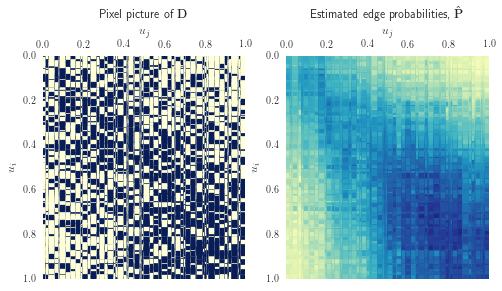

In [70]:
# Create n = N choose 2 vectors with the dyad types as values
u = np.zeros((N,N))
v = np.zeros((N,N))

for (i,j) in it.combinations(xrange(0,N), 2):
    u[i,j] = U[i]
    v[i,j] = U[j]
    
u = u + u.T
v = v + v.T

#------------------------------------------#
#- Create figure object with two subplots -#
#------------------------------------------#

pixel_ex_fig = plt.figure(figsize=(8,4))

# Plot 1: Plot pixel picture of adjacency matrix
ax = pixel_ex_fig.add_subplot(121)

# Scatter of adjacency matrix; edgecolors of pixels same as faces
plt.scatter(v[ij_LowTri],u[ij_LowTri],c=D[ij_LowTri], marker='s', cmap="YlGnBu", \
            edgecolors='face')

# Set axis limits 
plt.ylim([0,1])
plt.xlim([0,1])

# Label and configure axes to put pixel plot in "matrix form"
ax.xaxis.tick_top() # Put x-axis on top of figure
ax.set_xlabel(r'$u_{j}$', fontsize=12)
ax.xaxis.set_label_position('top') 

ax.invert_yaxis()  # Invert y-axis 
ax.set_ylabel(r'$u_{i}$', fontsize=12)

# Add title
plt.title(r"Pixel picture of $\mathbf{D}$", y=1.15, fontsize=12)

# Plot 2: Plot pixel picture of smoothed adjacency matrix
ax = pixel_ex_fig.add_subplot(122)

# Scatter
plt.scatter(v[ij_LowTri],u[ij_LowTri],c=P_ns[ij_LowTri], marker='s', cmap="YlGnBu", \
            edgecolors='face')

# Set axis limits 
plt.ylim([0,1])
plt.xlim([0,1])

# Label and configure axes to put pixel plot in "matrix form"
ax.xaxis.tick_top() # Put x-axis on top of figure
ax.set_xlabel(r'$u_{j}$', fontsize=12)
ax.xaxis.set_label_position('top') 

ax.invert_yaxis()  # Invert y-axis 
ax.set_ylabel(r'$u_{i}$', fontsize=12)

# Add title
plt.title(r"Estimated edge probabilities, $\mathbf{\hat{P}}$", y=1.15, fontsize=12)

# Save the figure
plt.savefig(graphics+'pixel_smooth_ex_fig.png', bbox_inches='tight', dpi=500)

In [57]:
X = 2*(D - 1/2) 
U, s, V = np.linalg.svd(X, full_matrices=True)
print np.linalg.matrix_rank(p)

1000


In [69]:
#P_ns = NeighborhoodSmoothing(D, 25)
P_ns = Levina(D,200)

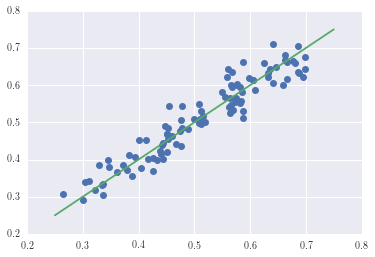

In [63]:
random_indices = np.random.choice(n, 100)
plt.plot(p[ij_LowTri][random_indices], P_ns[ij_LowTri][random_indices], 'o')
plt.plot([0.25,0.75],[0.25,0.75],'-')

In [64]:
USVT = (s >= (2+0.01)*(N**0.5))
W = np.dot(np.dot(U,np.diag(USVT*s)),V) 
W = W*(W>=-1)*(W<=1) - 1*(W<-1) + 1*(W>1)    
W = 0.5 + 0.5*W

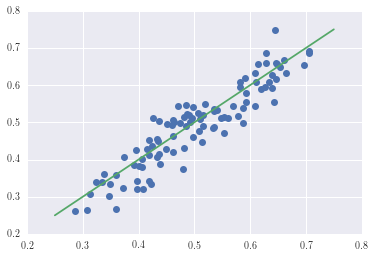

In [65]:
random_indices = np.random.choice(n, 100)
plt.plot(p[ij_LowTri][random_indices], W[ij_LowTri][random_indices], 'o')
plt.plot([0.25,0.75],[0.25,0.75],'-')

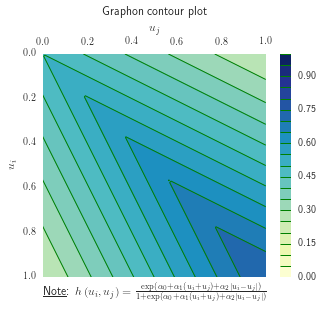

In [66]:
# Plot test graphon function

# Create mesh grid of x, y, z values
U    = np.linspace(0, 1, 100)
u, v = np.meshgrid(U, U)
h    = 1/(1+np.exp(-alpha0 - alpha1*(u + v) - alpha2*np.abs(u - v))) #Homophily graphon

# Create figure object
graphon_ex_fig = plt.figure(figsize=(5,4))
ax = graphon_ex_fig.add_subplot(111)

# Create contour "heat map" with 20 levels
cs1 = ax.contourf(u, v, h, levels=np.linspace(0, 1, 21), \
           origin='upper', extent=(0,1,0,1), cmap="YlGnBu")

# Add contour lines to plot
cs2 = plt.contour(cs1, \
                  colors='green', linewidths = 1)
# Add color bar
cbar = graphon_ex_fig.colorbar(cs1, format="%.2f").add_lines(cs2)

# Label and configure axes to put graphon plot in "matrix form"
ax.xaxis.tick_top() # Put x-axis on top of figure
ax.set_xlabel(r'$u_{j}$', fontsize=12)
ax.xaxis.set_label_position('top') 

ax.invert_yaxis()  # Invert y-axis 
ax.set_ylabel(r'$u_{i}$', fontsize=12)

# Add title
plt.title("Graphon contour plot", y=1.15, fontsize=12)

# Add graphon equation as note at the bottom of the plot
from matplotlib import rc
rc('text', usetex=True)
plt.text(0, 1.1, r'\underline{Note}: $h\left(u_{i},u_{j}\right)=\frac{\exp\left(\alpha_{0}+\alpha_{1}\left(u_{i}+u_{j}\right) \
                   +\alpha_{2}\left|u_{i}-u_{j}\right|\right)}{1+\exp\left(\alpha_{0}+\alpha_{1}\left(u_{i}+u_{j}\right) \
                   +\alpha_{2}\left|u_{i}-u_{j}\right|\right)}$', fontsize=12)


# Save the figure
plt.savefig(graphics+'graphon_ex_fig.png', bbox_inches='tight', dpi=500)